# Modeling

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from fbprophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import logging
logging.getLogger().setLevel(logging.ERROR)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline 

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize tho

In [2]:
raw_df = pd.read_csv('data/train_df.csv', parse_dates=['date'])

Outlier removal steps as developed in another analysis

In [3]:
id_out = [11, 14, 15, 12]
raw_df.loc[(raw_df.date == '2013-11-29') & (raw_df.item_category_id.isin(id_out)), 'sales'] = np.nan
raw_df.loc[(raw_df.date_block_num == 10) & (raw_df.item_category_id.isin(id_out))].interpolate(method='linear');
raw_df.head()

,date,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_day,sales
0,2013-01-02,0,59,"Ярославль ТЦ ""Альтаир""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
1,2013-01-02,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
2,2013-01-03,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
3,2013-01-20,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
4,2013-01-23,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0


In [4]:
ts_data = raw_df[['date','sales']]

In [5]:
ts_daily = ts_data.groupby(['date'])['sales'].sum()
ts_daily.head()

date
2013-01-01    1362942.00
2013-01-02    6020512.03
2013-01-03    5436480.11
2013-01-04    4755664.00
2013-01-05    4587231.00
Name: sales, dtype: float64

### ARMA model (baseline model)

We will start with model order 1 to get a naive based model predictions on sales. We split the dataset into train (Jan 2013 - Jul 2015) and test (Aug 2015 - Oct 2015).

In [6]:
pred_period = 30  # roughly representOct 2015

In [7]:
ts_train = ts_daily[:-pred_period]
ts_test = ts_daily[-pred_period:]

In [8]:
mod = ARMA(ts_train, order=(1,0), freq='D')
res = mod.fit()
arma = res.predict(start=ts_test.index[0], end=ts_test.index[-1])

In [9]:
arma_rmse = np.sqrt(mean_squared_error(ts_test, arma))
print('RMSE is {:,.0f}'.format(arma_rmse))

RMSE is 1,313,199


Above is the 1st order model result. RSME is the model evaluation KPIs
<br>
We will now run through the train and predict for the following models

- SARIMA model
- Prophet
- Holt Winter’s Exponential Smoothing
- Multivariate Time Series Model

### SARIMA

Use auto_arima to find the optimal orders

In [10]:
stepwise_fit = pm.auto_arima(ts_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12, #set m=12 based on seaonality observations from exploratory analysis
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=31342.744, BIC=31367.237, Fit time=2.575 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=31962.075, BIC=31971.873, Fit time=0.125 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=31631.037, BIC=31650.632, Fit time=1.235 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=31375.953, BIC=31395.548, Fit time=1.796 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=31336.799, BIC=31366.191, Fit time=3.661 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=31518.383, BIC=31542.876, Fit time=3.486 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=31336.549, BIC=31370.840, Fit time=12.327 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=31372.793, BIC=31402.185, Fit time=15.068 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=31301.115, BIC=31340.305, Fit time=17.801 seconds
Fit ARI

In [11]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1004
Model:             SARIMAX(3, 1, 3)x(1, 1, 2, 12)   Log Likelihood              -15603.161
Date:                            Sun, 09 Feb 2020   AIC                          31228.322
Time:                                    14:12:16   BIC                          31282.208
Sample:                                         0   HQIC                         31248.811
                                           - 1004                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6340.5101   7075.848      0.896      0.370   -7527.897    2.02e+04
ar.L1          0.0551      0.057      0.975      0.330      -0.056       0.166
ar.L2         -0.7734      0.029    -27.076      0.000      -0.829      -0.717
ar.L3          0.4983      0.053      9.337      0.000       0.394       0.603
ma.L1         -0.4291      0.052     -8.319      0.000      -0.530      -0.328
ma.L2          0.6066      0.037     16.560      0.000       0.535       0.678
ma.L3         -0.8516      0.043    -19.606      0.000      -0.937      -0.766
ar.S.L12      -0.8724      0.781     -1.117      0.264      -2.403       0.658
ma.S.L12      -0.0823      0.815     -0.101      0.920      -1.681       1.516
ma.S.L24      -0.8091      0.767     -1.054      0.292      -2.313       0.695
sigma2      4.663e+12   6.28e-05   7.43e+16      0.000    4.66e+12    4.66e+12
===================================================================================
Ljung-Box (Q):                      195.74   Jarque-Bera (JB):             37982.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.82   Skew:                             2.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.02e+32. Standard errors may be unstable.
"""

In [12]:
mod_1 = SARIMAX(ts_train, order=(3,1,3), seasonal_order=(2,1,2,12), freq='D')
res_1 = mod_1.fit()
sarimax = res_1.predict(start=ts_test.index[0], end=ts_test.index[-1])

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [13]:
sarx_rmse = np.sqrt(mean_squared_error(ts_test, sarimax))
print('RMSE is {:,.0f}'.format(sarx_rmse))

RMSE is 1,119,824


### Holt Winter’s Exponential Smoothing

In [14]:
mod_h = ExponentialSmoothing(ts_train, seasonal_periods=12, trend='add', seasonal='add', freq='D', damped=True)
res_h = mod_h.fit(use_boxcox=True)
holt_w = res_h.predict(start=ts_test.index[0], end=ts_test.index[-1])

In [15]:
holt_w_rmse = np.sqrt(mean_squared_error(ts_test, holt_w))
print('RMSE is {:,.0f}'.format(holt_w_rmse))

RMSE is 1,455,483


### Prophet

The model works well with continuous time data. We will switch apply the daily level data set to the model

In [16]:
prophet_df = ts_daily.reset_index()
prophet_df.columns = ['ds','y']
prophet_df.ds = pd.to_datetime(prophet_df.ds)
prophet_df.y = prophet_df.y.astype('float')

In [17]:
prophet_train = prophet_df[:-pred_period]

In [18]:
m = Prophet()
m.fit(prophet_train)
future = m.make_future_dataframe(periods=pred_period, freq='D')
fcst = m.predict(future)

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\fbprophet\forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [19]:
fcst_data = fcst[['ds', 'yhat']][-pred_period:]
fcst_data.set_index(fcst_data['ds'],inplace=True)

In [20]:
prophet = pd.Series(fcst_data['yhat'], index=fcst_data.index)

In [21]:
prophet_rmse = np.sqrt(mean_squared_error(ts_test, prophet))
print('RMSE is {:,.0f}'.format(prophet_rmse))

RMSE is 1,228,404


### VARMAX (Mulitvariate Time Series)

In exploratory anaylsis, we found out top 7 item categories which made up of 92% of total sales, but each category has different time series trend. We want to see if we predict each of the categories independently, and them up, would the total sales be more reflective to certain sales spikes and dips driven by category's sales trend.

In [22]:
product = raw_df.groupby(['date','item_category_name'])['sales'].sum().reset_index(drop=False)
product[['sub_cat', 'prod_name']] = product['item_category_name'].str.split('-', n=1, expand=True)
product['sub_cat'] = product['sub_cat'].apply(lambda x: x.strip().lower())

In [23]:
subcat = product.groupby(['date','sub_cat'])['sales'].sum().reset_index(drop=False)

In [24]:
#below are top categoroies identified in exploratory analysis, which account for 92% of total sales
top_cat = ['игры','игровые консоли','игры pc', 'кино','подарки','аксессуары','музыка','программы']

In [25]:
top_subcat = subcat[subcat.sub_cat.isin(top_cat)]

In [26]:
top_subcat_pivot = top_subcat.pivot_table(index=['date'],columns=['sub_cat'], values=['sales'],aggfunc='sum')
top_subcat_pivot.fillna(0, inplace=True)

In [27]:
top_subcat_pivot.columns = top_subcat_pivot.columns.droplevel(0)

In [28]:
top_subcat_pivot = top_subcat_pivot.reset_index().rename_axis(None, axis=1)
top_subcat_pivot.set_index('date', inplace=True)

In [29]:
top_subcat_pivot.head()

,аксессуары,игровые консоли,игры,игры pc,кино,музыка,подарки,программы
date,,,,,,,,
2013-01-01,97215.64,145862.19,454649.02,197964.88,222527.07,73564.00,106967.55,33820.5
2013-01-02,422891.94,727517.44,1954434.39,1006318.60,931280.32,255983.24,423317.20,214492.0
2013-01-03,320383.64,737108.69,1610288.80,920252.60,811190.09,240147.70,430784.29,252577.8
2013-01-04,280097.71,637587.70,1391984.29,813228.20,743643.40,214576.00,309813.70,287687.0
2013-01-05,271020.12,665181.30,1330159.88,755777.30,694589.00,235789.25,354180.45,197081.7


In [30]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [31]:
cat_train = top_subcat_pivot[:-pred_period]

In [32]:
model = VARMAX(cat_train, order=(3, 3), freq='D') # reuse the orders identified in SARIMA model
model_fit = model.fit(maxiter=10, disp=False)

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [33]:
varx = model_fit.predict(start=ts_test.index[0], end=ts_test.index[-1]).sum(axis=1)/.92 #pro-rated back to 100% of sales

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



In [34]:
varx_rmse = np.sqrt(mean_squared_error(ts_test, varx))
print('RMSE is {:,.0f}'.format(varx_rmse))

RMSE is 1,324,069


### Models Comparison

In [35]:
#daily average sale during the predict period
daily_avg = np.mean(ts_test)

In [36]:
model = pd.DataFrame({'model': ['ARMA', 'SARIMAX', 'Holt Winter','Prophet', 'VARMAX'], 
                      'RMSE': [arma_rmse, sarx_rmse, holt_w_rmse, prophet_rmse, varx_rmse],
                      'daily_RMSE%':[arma_rmse/daily_avg, sarx_rmse/daily_avg, holt_w_rmse/daily_avg, prophet_rmse/(daily_avg), varx_rmse/daily_avg]
                      
                     })
model.set_index('model', inplace=True)

In [37]:
model

,RMSE,daily_RMSE%
model,,
ARMA,1.313199e+06,0.483108
SARIMAX,1.119824e+06,0.411968
Holt Winter,1.455483e+06,0.535452
Prophet,1.228404e+06,0.451913
VARMAX,1.324069e+06,0.487107


##### Graphically

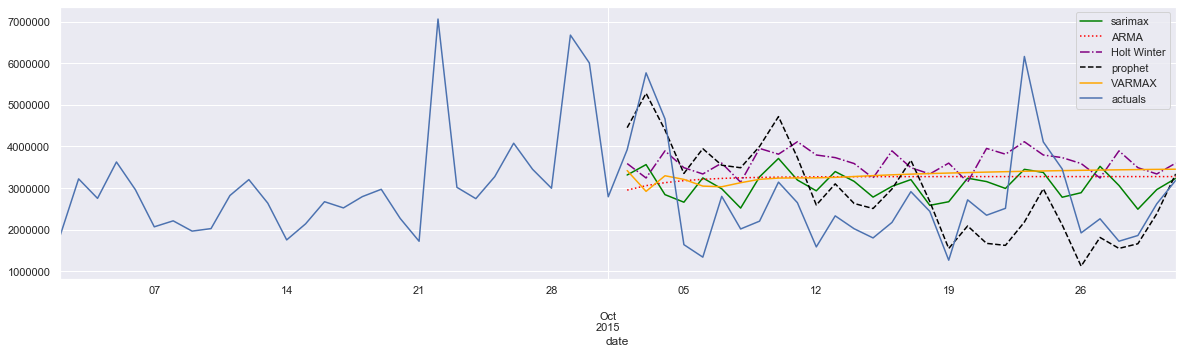

In [40]:
plt.figure(figsize=(20,5))
sarimax.plot(color='green', label='sarimax')
arma.plot(color='red', linestyle=':', label='ARMA')
holt_w.plot(color='purple', linestyle='-.', label='Holt Winter')
prophet.plot(color='black', linestyle='--', label='prophet')
varx.plot(color='orange', linestyle='-', label='VARMAX')
ts_daily[-60:].plot(label='actuals')
plt.legend(loc='best')
plt.show()

### Observations

SARIMAX has the smallest RSME. Prophet, given its simplistic development and fast exeuction, rank a strong second.
<br>
However, all the time series models did not perform that much better than the base model. From the graphical results, we also see that there are days that the projections were way off (on daily average, RMSE is 40% off). We would make an initial conclusion that time series models are not the best model on predicting sales at the daily level. The errors will likely to get bigger as we try to drill down to store/product level.

Possible reasons that time-series models do not work in this case are limited amount of sales data by date. Sales spikes could be highly depending on product/marketing factors that are independent of time. At the daily level, the sales pattern is not very stationary.

### Next Steps

We will explore classifications and ensemble models to identify improvements to prediction.